# Deep learning for state-space identification
## Application to identification of cascaded tanks system

### Course on Deep Learning for System Identification
### Authors: Marco Forgione, Dario Piga
### Lugano, April 4th, 2024

Estimate a neural state-space model of the system, under the following physical information:

- Model #1. The only physical information used is state dimension (nx = 2)
- Model #2. Same information used to construct Model #1 and: $y=x_2$ (namely, the g funtion is known)
- Model #3. Same information used to construct Model #2 and state $x_1$ does not depend on $x_2$.

Run the following cells to load data, create train/test sets, normalize the data

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import torch
from torch import nn as nn
%matplotlib widget 

In [3]:
# data loading

folder = os.path.join(
    "..", "..", "data", "CascadedTanks"
)  # change path according to the location of your csv file
file = os.path.join(folder, "dataBenchmark.csv")
dataset = pd.read_csv(file)
print("\n Dataset info: \n")


# rename the columns in training and test sequences (we typically call validation set the one used to tune algorithms' hyper-parameters)
dataset = dataset.rename(
    columns={
        "uEst": "u_train",
        "uVal": "u_test",
        "yEst": "y_train",
        "yVal": "y_test",
    }
)
print(dataset)

u_train = torch.tensor(dataset["u_train"], dtype=torch.float32)
y_train = torch.tensor(dataset["y_train"], dtype=torch.float32)

u_test = torch.tensor(dataset["u_test"], dtype=torch.float32)
y_test = torch.tensor(dataset["y_test"], dtype=torch.float32)


 Dataset info: 

      u_train   u_test  y_train  y_test   Ts  Unnamed: 5
0      3.2567  0.97619   5.2050  4.9728  4.0         NaN
1      3.2466  0.99921   5.2154  4.9722  NaN         NaN
2      3.2309  1.01720   5.2215  4.9703  NaN         NaN
3      3.2097  1.03180   5.2142  4.9880  NaN         NaN
4      3.1836  1.04560   5.2001  4.9825  NaN         NaN
...       ...      ...      ...     ...  ...         ...
1019   3.2300  0.83275   3.6672  3.7881  NaN         NaN
1020   3.2451  0.85406   3.6379  3.7978  NaN         NaN
1021   3.2554  0.88351   3.6883  3.7807  NaN         NaN
1022   3.2610  0.91620   3.6831  3.7151  NaN         NaN
1023   3.2615  0.94805   3.6831  3.7179  NaN         NaN

[1024 rows x 6 columns]


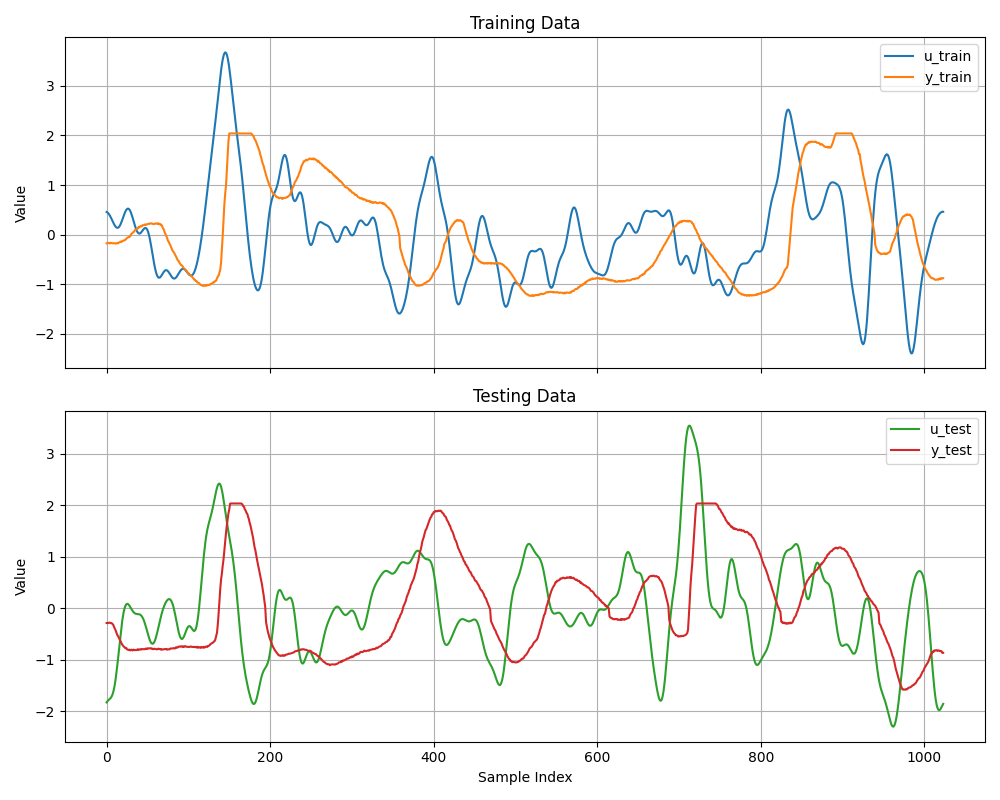

In [5]:
fig, axs = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

# Plot training data
axs[0].plot(u_train.numpy(), label='u_train', color='tab:blue')
axs[0].plot(y_train.numpy(), label='y_train', color='tab:orange')
axs[0].set_title('Training Data')
axs[0].set_ylabel('Value')
axs[0].legend()
axs[0].grid(True)

# Plot test data
axs[1].plot(u_test.numpy(), label='u_test', color='tab:green')
axs[1].plot(y_test.numpy(), label='y_test', color='tab:red')
axs[1].set_title('Testing Data')
axs[1].set_xlabel('Sample Index')
axs[1].set_ylabel('Value')
axs[1].legend()
axs[1].grid(True)

plt.tight_layout()
plt.show()

In [4]:
# scaling
u_mean = torch.mean(u_train)
u_std = torch.std(u_train)
y_mean = torch.mean(y_train)
y_std = torch.std(y_train)

u_train = (u_train - u_mean) / u_std
u_test = (u_test - u_mean) / u_std

y_train = (y_train - y_mean) / y_std
y_test = (y_test - y_mean) / y_std

In [6]:
# Adapted from pytorch-ident, https://github.com/forgi86/pytorch-ident/blob/master/torchid/ss/dt/models.py
# Implements a state-update function f(x, u)
class NeuralStateUpdate(nn.Module):

    def __init__(self, n_x=2, n_u=1, n_feat=32):
        super().__init__()
        
        self.net = nn.Sequential(
            nn.Linear(n_x+n_u, n_feat),
            nn.Tanh(),
            nn.Linear(n_feat, n_x),
        )
        
        for m in self.net.modules():
            if isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, mean=0, std=1e-2)
                nn.init.constant_(m.bias, val=0)


    def forward(self, x, u):
        z = torch.cat((x, u), dim=-1)
        dx = self.net(z)
        return dx

In [7]:
# Adapted from pytorch-ident, https://github.com/forgi86/pytorch-ident/blob/master/torchid/ss/dt/models.py
# Implements the output function g(x). In fact, it is just a standard feedforward net
class NeuralOutput(nn.Module):

    def __init__(self, n_x, n_y, n_feat=32):
        super().__init__()
        
        self.net = nn.Sequential(
            nn.Linear(n_x, n_feat),
            nn.Tanh(),
            nn.Linear(n_feat, n_y),
        )
                    
    def forward(self, x):
        y = self.net(x)
        return y

In [8]:
# Adapted from pytorch-ident, https://github.com/forgi86/pytorch-ident/blob/master/torchid/ss/dt/models.py
# Unrolls the state-update function f(x,u) over time, starting from an initial state x_0

class StateSpaceSimulator(nn.Module):
    def __init__(self, f_xu):
        super().__init__()
        self.f_xu = f_xu

    def forward(self, x_0, u):
        B, n_x = x_0.shape
        _, T, _ = u.shape # B, T, n_u
        x = torch.empty((B, T, n_x))
        x_step = x_0

        # manually unroll f_xu over time
        for t in range(T): 
            x[:, t, :] = x_step
            dx = self.f_xu(x_step, u[:, t, :])
            x_step = x_step + dx

        return x

In [21]:
n_y = 1; n_x = 2; n_u = 1
B = 1 # just one sequence
T = 1024
u_batch = u_train.unsqueeze(0).unsqueeze(-1)
y_batch = y_train.unsqueeze(0).unsqueeze(-1)

print(u_batch.shape)
print(y_batch.shape)

torch.Size([1, 1024, 1])
torch.Size([1, 1024, 1])


In [22]:
x0 = torch.zeros((B, n_x), requires_grad=True) # this is also a training variable which requires gradients
f_xu = NeuralStateUpdate(n_x, n_u, n_feat=32)
g_x = NeuralOutput(n_x, n_y)
simulator = StateSpaceSimulator(f_xu)

In [23]:
opt = torch.optim.AdamW(
    [
        {"params": f_xu.parameters(), "lr": 1e-3},
        {"params": g_x.parameters(), "lr": 1e-3},
        {"params": x0, "lr": 1e-3},
    ],
    1e-3, # default
)
# opt = torch.optim.AdamW(list(f_xu.parameters()) + list(g_x.parameters()) + [x0], 1e-3)

In [24]:
x_sim = simulator(x0, u) # B, T, n_x
y_sim = g_x(x_sim) # # B, T, n_y
loss = torch.nn.functional.mse_loss(y, y_sim) # torch.mean((y - y_sim)**2)
loss

tensor(1.0355, grad_fn=<MseLossBackward0>)

In [ ]:
# Overall, we have defined a custom RNN. In fact, it behaves pretty much like a standard LSTM (with batch_first=True)
rnn = torch.nn.RNN(input_size=n_u, hidden_size=n_x, batch_first=True, num_layers=1)
batch_h, _ = rnn(u_batch) # returns both hidden sequence and last hidden layes
batch_h.shape

torch.Size([1, 1024, 2])

## Hint

Have a look at the provided playground script, where a *NeuralStateUpdate* class is already defined, along with a *StateSpaceSimulator* class which can be used to simulate the evolution of the state for a given instance of the *NeuralStateUpdate* class, a given initial condition $x0$, and a given input sequence $u$.